# PHYS6318: Lecture 1

PHYS 6318 will follow the textbooks *Ocean Modelling for Beginners* (OMB) and "Advanced Ocean Modelling" (AOM)  which are both written by Jochen Kampf.  We will consider them as "part 1" and "part 2" of a comprehensive work.

[Ocean Modelling for Beginners | SpringerLink (mun.ca)](https://link-springer-com.qe2a-proxy.mun.ca/book/10.1007%2F978-3-642-00820-7)

[Advanced Ocean Modelling | SpringerLink (mun.ca)](https://link-springer-com.qe2a-proxy.mun.ca/book/10.1007%2F978-3-642-10610-1)

Both books are available as eTexts through the MUN Library. An **expectation** of the course is that you will be reading the textbook as you learn the material. The textbooks use FORTRAN and SciLab. While FORTRAN is still extensively used for ocean modelling, this course will also use Python, Jupyter notebooks, and the plotting library Matplotlib to learn the material.  

## Evaluation

- Problem sets (6) 60%
- Project 30%
- Presentation 10%

The problem sets will be composed of tasks primarily based off the exercises from the textbooks. Approximately 3 or 4 *problems* will be assigned assigned per week throughout the course. Problem sets of groups of problems will be due every two weeks and are to be submitted as Jupyter Notebooks (.ipynb) through the Brightspace dropbox for the course.

The project and presentation will consist of a coding and running numerical simulations along with written report exploring a particular topic in ocean climate modelling. This will be assigned in the second half of the course and due at the end of the course.

There is no final exam for PHYS6318.

# OMB Chapter 1: Requirements


The author of the textbooks has made available several numerical codes referenced in the text. They are written in FORTRAN 90 and SciLab and may serve as useful references for your own implementation of some codes. These codes are available for download from

* OMB (2009) https://extras.springer.com/2009/978-3-642-00819-1.zip
* AMB (2010) https://extras.springer.com/2010/978-3-642-10609-5.zip


We will begin the course by using Jupyter Lab as the interface to write and run our computer codes.  We may learn about other text editors and compilers as needed. You will need to set up a JupterLab environment with at least the Python packages Numpy and Matplotlib.  And conda environment file `environment.yml` is available.  

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob
import xarray as xr
import netCDF4

# OMB Chapter 2: Motivation

## OMB 2.1 The Decay Problem

### 2.1.1 The Problem

Determine the concentration, $C$, of a material that is decaying at a rate of $\kappa = 0.0001\;\mbox{s}^{-1}$ over a duration of 24 hours according to the equation

$$\frac{dC}{dt} = -\kappa C$$

Assume that at $t = 0$ hours, $C_0 = 100$ g/mL.

### Analytical solution

This problem has analytical solution given by

$$ C = C_0 e^{-\kappa t}$$ 

In [2]:
# initial concentraion is 100
C0 = 100
# value of decay constant
κ = 0.0001 # \kappa[TAB] to type this in Jupyter

# value of time step in seconds
dt = 3600

# total simulation is 24 hours
# every hour is 60 minutes of 60 seconds each
ntot = int(24 * 3600 / dt)

for n in range(ntot):
  
    # time counter
    t = n * dt
    
    # exact analytical solution
    C = C0*np.exp(-κ*t)
    
    # output values at in terms of hours
    print(f"time = {t/3600:.0f} C = {C:.2f}")

time = 0 C = 100.00
time = 1 C = 69.77
time = 2 C = 48.68
time = 3 C = 33.96
time = 4 C = 23.69
time = 5 C = 16.53
time = 6 C = 11.53
time = 7 C = 8.05
time = 8 C = 5.61
time = 9 C = 3.92
time = 10 C = 2.73
time = 11 C = 1.91
time = 12 C = 1.33
time = 13 C = 0.93
time = 14 C = 0.65
time = 15 C = 0.45
time = 16 C = 0.32
time = 17 C = 0.22
time = 18 C = 0.15
time = 19 C = 0.11
time = 20 C = 0.07
time = 21 C = 0.05
time = 22 C = 0.04
time = 23 C = 0.03


In numerical modelling, we often to need iterate with smaller time steps than we need in the final output.

In [3]:
# initial concentraion is 100
C0 = 100
# value of decay constant
κ = 0.0001

# value of time step in seconds
dt = 3600

# total simulation is 24 hours
# every hour is 60 minutes of 60 seconds each
ntot = int(24 * 3600 / dt)

# data output at every 3 hours of the simulation
nout = int(3 * 3600 / dt)
           
for n in range(ntot):
  
    # time counter
    t = n * dt
    
    # exact analytical solution
    C = C0*np.exp(-κ*t)
    
    # Data out if the counter is constant integer multiple of nout
    # For instance, nout = 30 produces outputs at i = 30, 60, 90, ...
    if n % nout == 0:
        print(f"time = {t/3600:.0f} C = {C:.2f}")

time = 0 C = 100.00
time = 3 C = 33.96
time = 6 C = 11.53
time = 9 C = 3.92
time = 12 C = 1.33
time = 15 C = 0.45
time = 18 C = 0.15
time = 21 C = 0.05


While these files could be put together in a NumPy array, or saved to a .csv file, we are going to save our output as a NetCDF file.

In [4]:
def init_output(basename, **attrs):
    
    # ensure we are writing to a new file each time
    previous_files = sorted(glob.glob(f'OUTPUT/{basename}_*.nc'))
    if len(previous_files) == 0:
        counter = 1    
    else:
        counter = int(previous_files[-1][-7:-3]) + 1
    filename = f'OUTPUT/{basename}_{counter:04d}.nc'
        
    nc = netCDF4.Dataset(filename, "w")

    # NetCDF files have 'dimensions'
    nc.createDimension("time")

    # NetCDF files have 'variables'
    nc.createVariable("time", "f8", ("time",))
    # NetCDF variables can have 'attributes'
    nc.variables["time"].units = "hours since 2000-01-01"
    nc.variables["time"].calendar = "gregorian"
    
    nc.createVariable("concentration", "f8", ("time",))
    nc.variables["concentration"].units = "g/mL"

    # NetCDF files have also have global attributes
    nc.setncatts(attrs)
    nc.history = "Created " + time.ctime(time.time())
    nc.source = "OMB Exercise 1"
    nc.filename = filename

    # It is important to close a NetCDF file
    nc.close()
    
    return filename

In [5]:
def write_output(filename, t, C, n=None):
    # open a NetCDF file in 'append' mode
    nc = netCDF4.Dataset(filename, mode='a')
    
    # if n is not provided, place values in the last position
    if n is None:
        n = len(nc.variables['time'])
        
    # t is units of seconds, while 'time' is in hours
    nc.variables["time"][n] = t/3600
    nc.variables["concentration"][n] = C
    
    # It is important to close a NetCDF file
    nc.close()

In [6]:
filename = init_output('decay_analytic', method='analytic')

# initial concentraion is 100
C0 = 100
# value of decay constant
κ = 0.0001

# value of time step in seconds
dt = 3600

# total simulation is 24 hours
# every hour is 60 minutes of 60 seconds each
ntot = int(24 * 3600 / dt)

# data output at every 3 hours of the simulation
nout = int(3 * 3600 / dt)

for n in range(ntot):
  
    # time counter
    t = n * dt
    
    # exact analytical solution
    C = C0*np.exp(-κ*t)
    
    # Data out if the counter is constant integer multiple of nout
    # For instance, nout = 30 produces outputs at i = 30, 60, 90, ...
    if n % nout == 0:
        print(f"time = {t/3600:.0f} C = {C:.2f}")
        
        write_output(filename, t, C)

time = 0 C = 100.00
time = 3 C = 33.96
time = 6 C = 11.53
time = 9 C = 3.92
time = 12 C = 1.33
time = 15 C = 0.45
time = 18 C = 0.15
time = 21 C = 0.05


Saving our output as NetCDF files allows us to use Xarray right away:

In [7]:
ds = xr.open_dataset(filename)
ds

<xarray.Dataset>
Dimensions:        (time: 8)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 ... 2000-01-01T21:00:00
Data variables:
    concentration  (time) float64 ...
Attributes:
    method:    analytic
    history:   Created Mon Jan 11 09:20:58 2021
    source:    OMB Exercise 1
    filename:  OUTPUT/decay_analytic_0001.nc

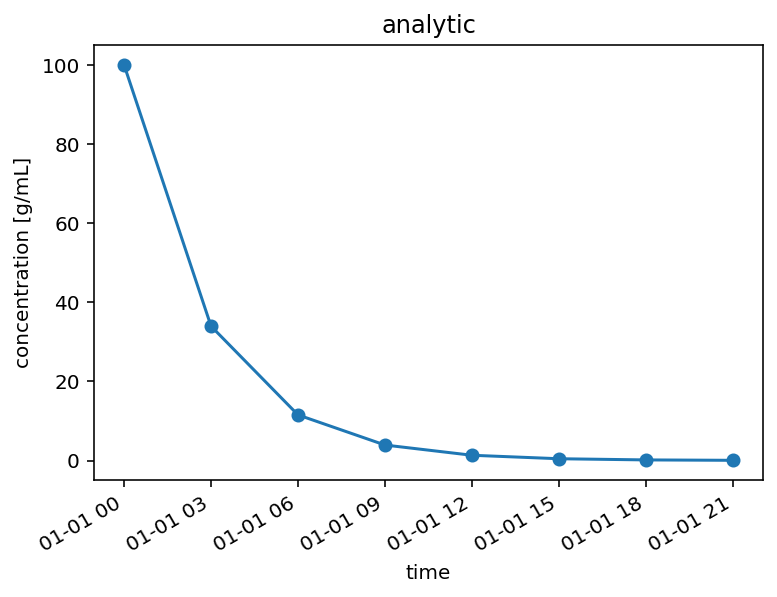

In [8]:
ds.concentration.plot(marker='o')
plt.title(ds.method)
plt.show()

Functions are important for keeping our code organized.

In [9]:
def decay_problem_analytic(
    C0 = 100, # initial concentraion is 100
    κ = 0.0001, # value of decay constant
    dt = 3600, # value of time step in seconds
    tmax = 24, # total simulation is 24 hours
    toutput = 3, # output at every 3 hours of the simulation
):
    
    filename = init_output('decay_analytic',
                method='analytic',
                dt=dt,
                κ=κ)

    # every hour is 60 minutes of 60 seconds each
    ntot = int(tmax * 3600 / dt)
    nout = int(toutput * 3600 / dt)

    for n in range(ntot):

        # time counter
        t = n * dt

        # exact analytical solution
        C = C0*np.exp(-κ*t)

        # Data output if the counter is constant integer multiple of nout
        # For instance, nout = 30 produces outputs at i = 30, 60, 90, ...
        if n % nout == 0:
            print(f"time = {t/3600:.0f} C = {C:.2f}")

            write_output(filename, t, C)
            
    return filename

In [10]:
def plot_solution(filename):
    ds = xr.open_dataset(filename)
    
    label = f'{ds.method}, dt={ds.dt}, κ={ds.κ}'
    ds.concentration.plot(marker='o', label=label)
    ds.close()

time = 0 C = 100.00
time = 3 C = 33.96
time = 6 C = 11.53
time = 9 C = 3.92
time = 12 C = 1.33
time = 15 C = 0.45
time = 18 C = 0.15
time = 21 C = 0.05


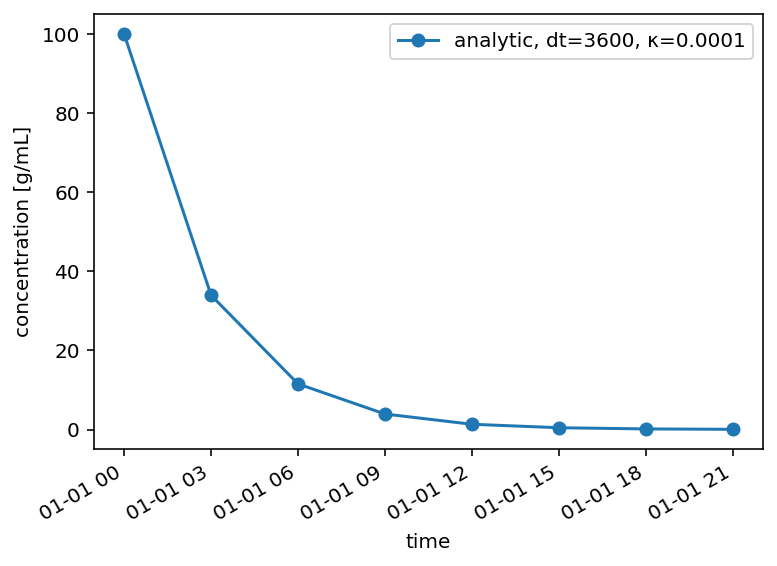

In [11]:
filename = decay_problem_analytic(toutput=3)
plot_solution(filename)
plt.legend()

## 2.2 First Steps with Finite Differences

### 2.2.1 Finite Time Step and Time Level

We can use a discrete *time step* $\Delta t$ = `dt` to rewrite our equation as

$$\frac{C^{n+1} - C^n}{\Delta t} = - \kappa C^n$$

The integer $n$ refers to the *time level*. By convention, $n$=0 gives the concentration at the start of the simulation, $n=1$ is the concentration after one time step, and so on.

### 2.2.2 Explicit Time-Forward Iteration

Rewrite the finite difference equation as

$$C^{n+1} = C^n - \Delta t \kappa C^n = (1 - \Delta t \kappa ) C^n$$

This method uses the values known a certain time level $n$ to predict the value of $C$ at the next time level $n+1$ and is therefore called *explicit time-forward iteration*.

### 2.2.3 Condition of Numerical Stability for Explicit Scheme

The explicit scheme is only stable if

$$ \Delta t < \frac{1}{\kappa}$$.

This *condition of numerical stability* says that the maximum time step that can be chosen depends on the value of $\kappa$.

In [12]:
def decay_problem_explicit(
    C0 = 100, # initial concentraion is 100
    κ = 0.0001, # value of decay constant
    dt = 3600, # value of time step in seconds
    tmax = 24, # total simulation is 24 hours
    toutput = 3, # output at every 3 hours of the simulation
):
    
    filename = init_output('decay_explicit',
                method='explicit',
                dt=dt,
                κ=κ)

    # every hour is 60 minutes of 60 seconds each
    ntot = int(tmax * 3600 / dt)
    nout = int(toutput * 3600 / dt)

    factor = 1 - dt*κ
    if factor < 0:
        print('Stability Criterion Alert: Reduce Time Step')
    
    C = C0
    t = 0

    # save initial values
    write_output(filename, t, C)
    
    for n in range(1, ntot):

        # time counter
        t = n * dt

        # prediction for the next time step
        C = factor*C

        # Data out if the counter is constant integer multiple of nout
        # For instance, nout = 30 produces outputs at i = 30, 60, 90, ...
        if n % nout == 0:
            print(f"time = {t/3600:.0f} C = {C:.2f}")

            write_output(filename, t, C)
            
    return filename


time = 0 C = 100.00
time = 3 C = 33.96
time = 6 C = 11.53
time = 9 C = 3.92
time = 12 C = 1.33
time = 15 C = 0.45
time = 18 C = 0.15
time = 21 C = 0.05
time = 3 C = 26.21
time = 6 C = 6.87
time = 9 C = 1.80
time = 12 C = 0.47
time = 15 C = 0.12
time = 18 C = 0.03
time = 21 C = 0.01


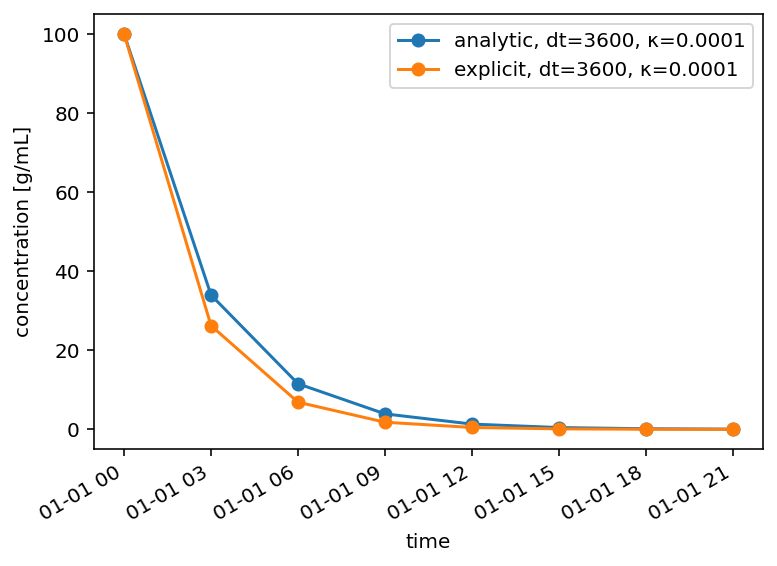

In [13]:
filename = decay_problem_analytic()
plot_solution(filename)
filename = decay_problem_explicit()
plot_solution(filename)
plt.legend()

### 2.2.4 Implicit Time-Forward Iteration

Another finite difference which is equivalent to the continous version of the equation is

$$\frac{C^{n+1} - C^n}{\Delta t} = - \kappa C^{n+1}$$

Solving for $C^n$ gives

$$C^{n+1} = \frac{C^n}{(1 + \Delta t \kappa)}$$

This implicit scheme is numerically stable for any value of $\Delta t$.

In [14]:
def decay_problem_implicit(
    C0 = 100, # initial concentraion is 100
    κ = 0.0001, # value of decay constant
    dt = 3600, # value of time step in seconds
    tmax = 24, # total simulation is 24 hours
    toutput = 3, # output at every 3 hours of the simulation
):
    
    filename = init_output('decay_implicit',
                method='implicit',
                dt=dt,
                κ=κ)

    # every hour is 60 minutes of 60 seconds each
    ntot = int(tmax * 3600 / dt)
    nout = int(toutput * 3600 / dt)

    factor = 1/(1 + dt*κ)
    
    C = C0
    t = 0

    # save initial values
    write_output(filename, t, C)
    
    for n in range(1, ntot):

        # time counter
        t = n * dt

        # prediction for the next time step
        C = C*factor
        
        # Data output if the counter is constant integer multiple of nout
        # For instance, nout = 30 produces outputs at i = 30, 60, 90, ...
        if n % nout == 0:
            print(f"time = {t/3600:.0f} C = {C:.2f}")

            write_output(filename, t, C)
            
    return filename

time = 0 C = 100.00
time = 3 C = 33.96
time = 6 C = 11.53
time = 9 C = 3.92
time = 12 C = 1.33
time = 15 C = 0.45
time = 18 C = 0.15
time = 21 C = 0.05
time = 3 C = 26.21
time = 6 C = 6.87
time = 9 C = 1.80
time = 12 C = 0.47
time = 15 C = 0.12
time = 18 C = 0.03
time = 21 C = 0.01
time = 3 C = 39.75
time = 6 C = 15.80
time = 9 C = 6.28
time = 12 C = 2.50
time = 15 C = 0.99
time = 18 C = 0.39
time = 21 C = 0.16


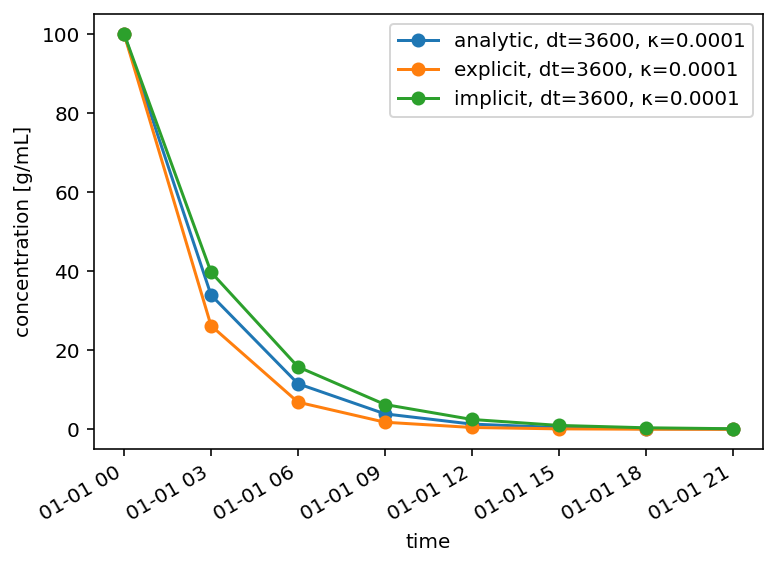

In [15]:
filename = decay_problem_analytic()
plot_solution(filename)
filename = decay_problem_explicit()
plot_solution(filename)
filename = decay_problem_implicit()
plot_solution(filename)
plt.legend()

The three versions of the solver ('analytic', 'explicit', and 'implicit') are very similar and can be combined together into one program.

In [16]:
def decay_problem(
    method='explicit',  # analytic, explicit, or implicit
    C0 = 100, # initial concentraion is 100
    κ = 0.0001, # value of decay constant
    dt = 3600, # value of time step in seconds
    tmax = 24, # total simulation is 24 hours
    toutput = 3, # output at every 3 hours of the simulation
    screen_output = False, # print info as program is run
):

    # every hour is 60 minutes of 60 seconds each
    ntot = int(tmax * 3600 / dt)
    nout = int(toutput * 3600 / dt)
    
    if method == 'explicit':
        factor = 1 - dt*κ
        if factor < 0:
            print('Stability Criterion Alert: Reduce Time Step')
    elif method == 'implicit':
        factor = 1/(1 + dt*κ)
      
    filename = init_output(f'decay_{method}',
                description= f"Decay Problem, {method}",
                method=method,
                dt=dt,
                κ=κ)
          
    C = C0
    t = 0
    
    # save initial values
    write_output(filename, t, C)

    for n in range(1, ntot):

        # time counter
        t = n * dt

        if method == 'analytic':
            # exact analytical solution
            C = C0*np.exp(-κ*t)
        else:
            # prediction for the next time step
            C = C*factor
            
        # Data output if the counter is constant integer multiple of nout
        # For instance, nout = 30 produces outputs at i = 30, 60, 90, ...
        if n % nout == 0:
            if screen_output:
                print(f"Output at time = {t/3600:.0f} {C:.2f}")

            write_output(filename, t, C)
            
    return filename

So now we can compare different numerical methods for the same problem:

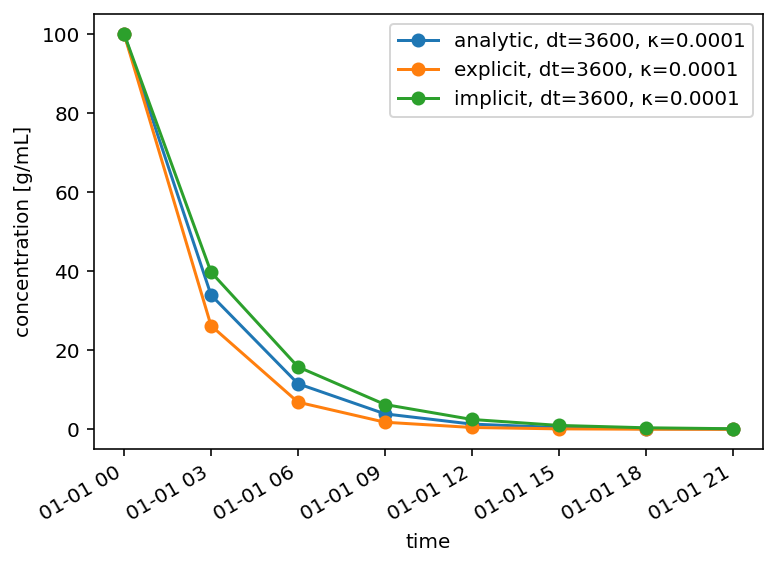

In [17]:
filename = decay_problem('analytic')
plot_solution(filename)
filename = decay_problem('explicit')
plot_solution(filename)
filename = decay_problem('implicit')
plot_solution(filename)

plt.legend()

Or the effect of changing a numerical method parameter:

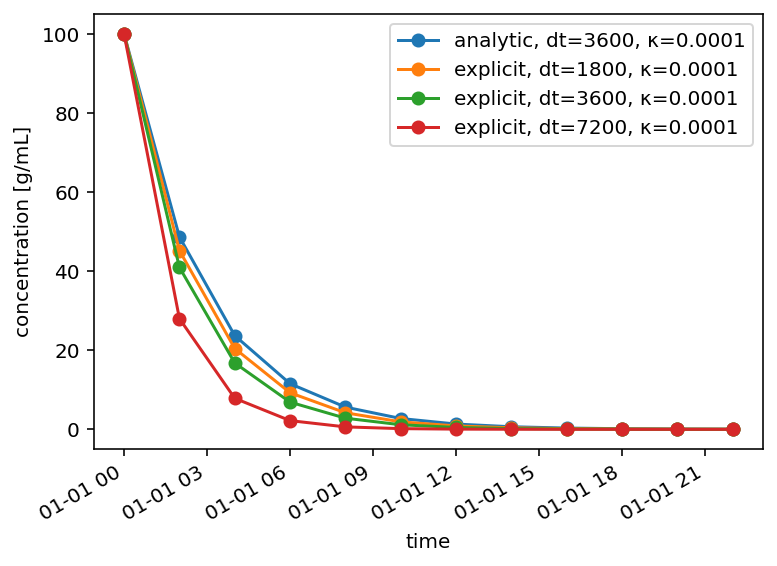

In [18]:
filename = decay_problem('analytic', toutput=2)
plot_solution(filename)

for dt in [1800, 3600, 7200]:
    filename = decay_problem('explicit', dt=dt, toutput=2)
    plot_solution(filename)

plt.legend()

Or changing a simulation parameter:

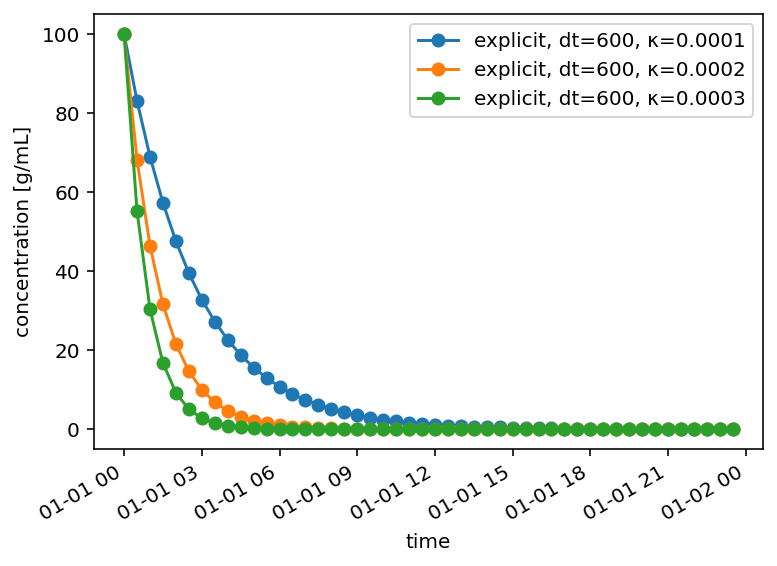

In [19]:
for κ in [0.0001, 0.0002, 0.0003]:
    filename = decay_problem('explicit', κ=κ, dt=600, toutput=0.5)
    plot_solution(filename)

plt.legend()

--- 
## Problem 1

Extend the program `decay_problem()` so that it supports an additional *hybrid scheme* that is dependent on a weighting factor $\alpha$ that ranges between zero and one (see OMB 2.2.5). Your completed solution to this exercise (submitted as a Jupyter notebook) should include the derivation of the numerical method starting from equation (2.7).

Complete the additional exercise OMB 2.3.6 by exploring the use of this hybrid scheme. Your solution should include a plot showing values of $\alpha = 0.0, 0.25, 0.5, 0.75,$ and $1.0$. You may modify `plot()` as needed or create a new program for visualization of your results. For fixed time step of $\Delta t = 3600$, which of these values of $\alpha$ gives the most **accurate** numerical solution as compared to the exact, analytical solution? 

--- 